In [1]:
import numpy as np 
import fanc
import fanc.plotting as fancplot
import matplotlib.pyplot as plt
import seaborn as sns
import pybedtools as pbt
import pandas as pd
import os

%matplotlib inline

In /fast/AG_Lupianez/rdoming/anaconda3/envs/hic/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /fast/AG_Lupianez/rdoming/anaconda3/envs/hic/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /fast/AG_Lupianez/rdoming/anaconda3/envs/hic/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /fast/AG_Lupianez/rdoming/anaconda3/envs/hic/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be remove

### 1. Calculate ctcf motifs

In [7]:
mm10_chromsizes = "../data/genomes/chrom-sizes/mm10.chrom.sizes"
mm10_fasta = "../data/genomes/mm10.fa"

In [9]:
def fimoMotifs(ctcf_filename,fasta,chromsizes,pwm="../data/bonev/aux/CTCF_meme_PWM.txt",fimopath="fimo"):
    prefix = os.path.splitext(ctcf_filename)[0]
    ctcf_fasta = prefix + ".fa"
    print(ctcf_fasta)
    ctcf = pbt.BedTool(ctcf_filename)
    ctcf = ctcf.sequence(fi=fasta)
    ctcf.save_seqs(ctcf_fasta)
    fimoFolder = prefix
    print("Running Fimo")
    !{fimopath} --bfile --motif-- --max-stored-scores 1000000 -o {fimoFolder} {pwm} {ctcf_fasta}
    fimoMotifs = pd.read_csv(fimoFolder + "/fimo.tsv",sep="\t",comment="#")
    topMotifs = fimoMotifs.sort_values(["sequence_name","q-value"]).drop_duplicates(subset="sequence_name")
    motifBed = pd.DataFrame(topMotifs["sequence_name"].str.split(":",expand=True))
    motifBed.columns = ["chrom","coord"]
    motifBed[["start","end"]] = motifBed["coord"].str.split("-",expand=True)
    del motifBed["coord"]
    motifBed[["name","score","strand"]] = topMotifs[["matched_sequence","score","strand"]]
    motifBedEnsembl = motifBed.copy()
    motifBedEnsembl["chrom"] = motifBedEnsembl["chrom"].str.extract("chr(.*)")
    motifBedEnsembl.query("strand=='+'").to_csv(prefix + "_plus.bed",sep="\t",index=False,header=False)
    motifBedEnsembl.query("strand=='-'").to_csv(prefix + "_minus.bed",sep="\t",index=False,header=False)
    return({"+":prefix + "_plus.bed","-":prefix + "_minus.bed"})

In [31]:
NPC_motifs = fimoMotifs(ctcf_filename="../data/bonev/CTCF_NPC/GSE96107_NPC_CTCF.IDR0.05.filt.narrowPeak.gz",
                        fasta=mm10_fasta,
                        chromsizes=mm10_chromsizes)
CN_motifs = fimoMotifs(ctcf_filename="../data/bonev/CTCF_CN/GSE96107_CN_CTCF.IDR0.05.filt.narrowPeak.gz",
                        fasta=mm10_fasta,
                        chromsizes=mm10_chromsizes)
PL_motifs = fimoMotifs(ctcf_filename="../data/duboule_hic/PFL.narrowPeak",
                        fasta=mm10_fasta,
                        chromsizes=mm10_chromsizes)
DL_motifs = fimoMotifs(ctcf_filename="../data/duboule_hic/DFL.narrowPeak",
                        fasta=mm10_fasta,
                        chromsizes=mm10_chromsizes)

../data/duboule_hic/PFL.fa
Running Fimo
Using motif +1 of width 19.
Using motif -1 of width 19.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=0.98022
../data/duboule_hic/DFL.fa
Running Fimo
Using motif +1 of width 19.
Using motif -1 of width 19.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=0.988041


In [61]:
PL = fanc.load("../data/duboule_hic/proximalLimb.hic@25000@KR")
DL = fanc.load("../data/duboule_hic/distalLimb.hic@25000@KR")
ES = fanc.load("../data/bonev/HiC/ES_mapq30/ES_mapq30.hic@25000@KR")
NPC = fanc.load("../data/bonev/HiC/NPC_mapq30/NPC_mapq30.hic@25000@KR")
CN = fanc.load("../data/bonev/HiC/CN_mapq30/CN_mapq30.hic@25000@KR")

##Genes plot
genes = "../data/genomes/mm10.coding.gtf"
genePlot = fancplot.GenePlot(genes,group_by="gene_id",squash=True,aspect=0.25,show_arrows=False,no_labels_outside_plot=True)

##Boundaries plot

boundaries = fancplot.GenomicFeaturePlot("9-Stable_boundary/boundary_coords.bed",aspect=0.01)

##ctcf plots
PL_ctcf = fancplot.LinePlot("../data/duboule_hic/PFL_E12_Wt_CTCF.bw",title="CTCF Proximal limb",aspect=0.1,colors=["gray"])
DL_ctcf = fancplot.LinePlot("../data/duboule_hic/DFL_E12_Wt_CTCF.bw",title="CTCF Distal limb",aspect=0.1,colors=["gray"])
ES_ctcf = fancplot.LinePlot("../data/bonev/CTCF_mESC/GSE96107_ES_CTCF.bw",title="CTCF ES",aspect=0.1,colors=["gray"])
NPC_ctcf = fancplot.LinePlot("../data/bonev/CTCF_NPC/GSE96107_NPC_CTCF.bw",title="CTCF NPC",aspect=0.1,colors=["gray"])
CN_ctcf = fancplot.LinePlot("../data/bonev/CTCF_CN/GSE96107_CN_CTCF.bw",title="CTCF CN",aspect=0.1,colors=["gray"])

#motif plots
#PL
PL_plus = fancplot.FeatureLayerPlot(PL_motifs["+"],aspect=0.025,collapse=True)
PL_minus = fancplot.FeatureLayerPlot(PL_motifs["-"],aspect=0.025,collapse=True)
#DL
DL_plus = fancplot.FeatureLayerPlot(DL_motifs["+"],aspect=0.025,collapse=True)
DL_minus = fancplot.FeatureLayerPlot(DL_motifs["-"],aspect=0.025,collapse=True)
#ES
ES_plus = fancplot.FeatureLayerPlot("2-CTCF-insulation/Bonev_mESC_CTCF+.bed",aspect=0.025,collapse=True)
ES_minus = fancplot.FeatureLayerPlot("2-CTCF-insulation/Bonev_mESC_CTCF-.bed",aspect=0.025,collapse=True)
#NPC
NPC_plus = fancplot.FeatureLayerPlot(NPC_motifs["+"],aspect=0.025,collapse=True)
NPC_minus = fancplot.FeatureLayerPlot(NPC_motifs["-"],aspect=0.025,collapse=True)
#CN
CN_plus = fancplot.FeatureLayerPlot(CN_motifs["+"],aspect=0.025,collapse=True)
CN_minus = fancplot.FeatureLayerPlot(CN_motifs["-"],aspect=0.025,collapse=True)

In [59]:
def plotHic(hic,title):
    vmax = np.percentile(hic.matrix((coords,coords)).flatten(),97.5)
    hicplot = fancplot.TriangularMatrixPlot(hic,vmax=vmax,title=title)
    return(hicplot)

In [8]:
PL_plot = plotHic(PL,"Proximal limb - Rodríguez-Carballo et al. 2017")
DL_plot = plotHic(DL,"Distal limb - Rodríguez-Carballo et al. 2017")
ES_plot = plotHic(ES,"ESC - Bonev et al. 2017")
NPC_plot = plotHic(NPC,"NPC - Bonev et al. 2017")
CN_plot = plotHic(CN,"CN - Bonev et al. 2017")

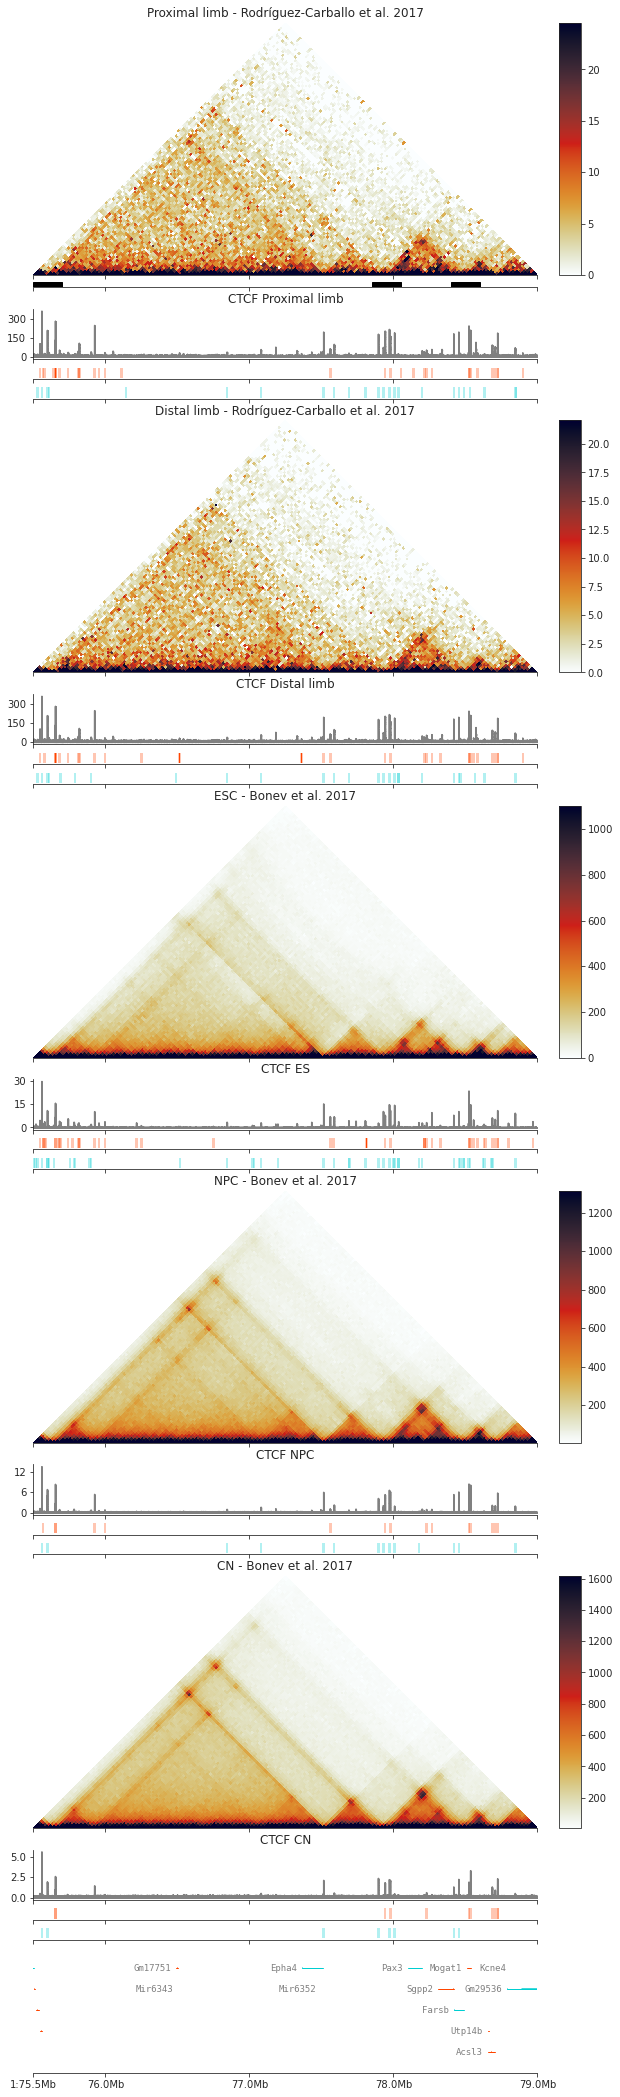

In [68]:
coords = "1:75.5mb-79mb"
gf = fancplot.GenomicFigure([PL_plot,boundaries,PL_ctcf,PL_plus,PL_minus,
                             DL_plot,DL_ctcf,DL_plus,DL_minus,
                             ES_plot,ES_ctcf,ES_plus,ES_minus,
                             NPC_plot,NPC_ctcf,NPC_plus,NPC_minus,
                             CN_plot,CN_ctcf,CN_plus,CN_minus,
                             genePlot],
                            width=7,
                            ticks_last=True)

gf.plot(coords)
plt.savefig("figurePlots/Stable_boundary_general.pdf")

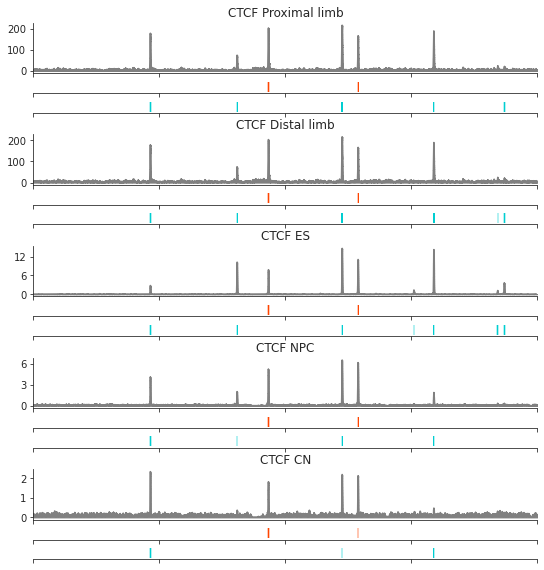

In [65]:
coords = "1:77.85mb-78.05mb"

gf = fancplot.GenomicFigure([PL_ctcf,PL_plus,PL_minus,
                             DL_ctcf,DL_plus,DL_minus,
                             ES_ctcf,ES_plus,ES_minus,
                             NPC_ctcf,NPC_plus,NPC_minus,
                             CN_ctcf,CN_plus,CN_minus],
                            width=7,
                            ticks_last=True)

gf.plot(coords) 
plt.savefig("figurePlots/Stable_boundary_delb.pdf")

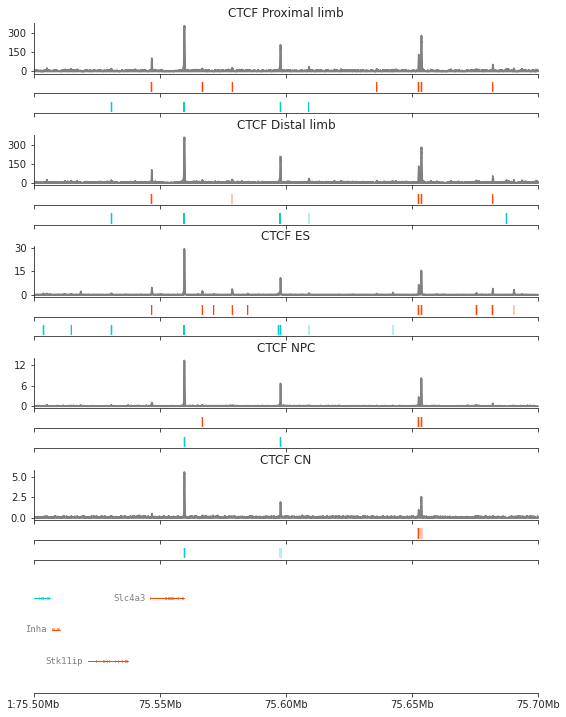

In [66]:
coords = "1:75.5mb-75.7mb"

gf = fancplot.GenomicFigure([PL_ctcf,PL_plus,PL_minus,
                             DL_ctcf,DL_plus,DL_minus,
                             ES_ctcf,ES_plus,ES_minus,
                             NPC_ctcf,NPC_plus,NPC_minus,
                             CN_ctcf,CN_plus,CN_minus,
                             genePlot],
                            width=7,
                            ticks_last=True)

gf.plot(coords) 
plt.savefig("figurePlots/Stable_boundary_centromeric.pdf")

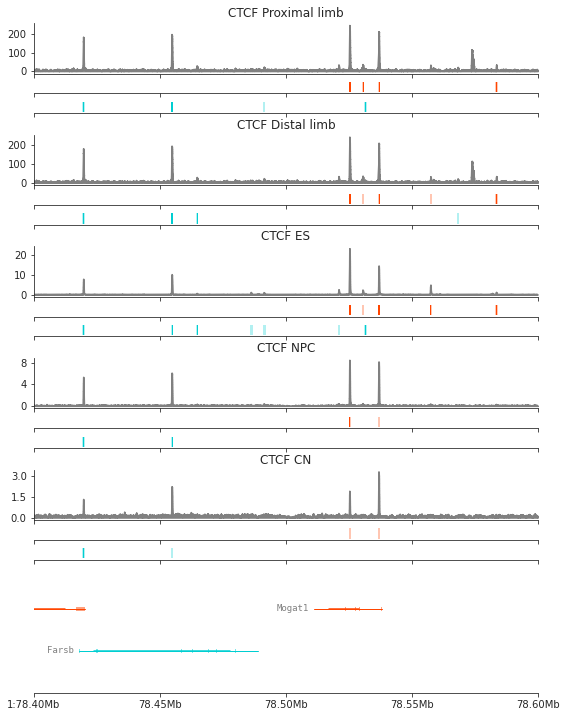

In [67]:
coords = "1:78.4mb-78.6mb"

gf = fancplot.GenomicFigure([PL_ctcf,PL_plus,PL_minus,
                             DL_ctcf,DL_plus,DL_minus,
                             ES_ctcf,ES_plus,ES_minus,
                             NPC_ctcf,NPC_plus,NPC_minus,
                             CN_ctcf,CN_plus,CN_minus,
                             genePlot],
                            width=7,
                            ticks_last=True)

gf.plot(coords) 
plt.savefig("figurePlots/Stable_boundary_telomeric.pdf")